In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from common.utils import load_variable, vote_by_user


# DORN

## Loading raw dataset

In [3]:
# File obtained from Cohort-comfort paper processing TODO add reference
df_dorn_features_raw = pd.read_csv("data/dorn/DORN_cozie_env_raw.csv")

df_dorn_features_raw['userid'] = ['dorn' + str(userid) for userid in df_dorn_features_raw['userid']]

print(f'Raw features:\n{df_dorn_features_raw.columns.values}')
print(f'Dimensions: {df_dorn_features_raw.shape}')
print('\nFeatures:')
print(df_dorn_features_raw['air-vel'].unique())
print(df_dorn_features_raw['location'].unique())
print(df_dorn_features_raw['clothing'].unique())
print(df_dorn_features_raw['met'].unique())
print(df_dorn_features_raw['met'].value_counts())
print(df_dorn_features_raw['comfort'].unique())
print(df_dorn_features_raw['indoorOutdoor'].unique())
print(df_dorn_features_raw['thermal'].unique())
print(df_dorn_features_raw['voteLog'].unique())
print('\nMissing rows:')
print(df_dorn_features_raw.isna().sum())
df_dorn_features_raw.head(5)


Raw features:
['time' 'BMR' 'air-vel' 'bodyPresence' 'change' 'clothing' 'comfort'
 'experimentid' 'heartRate' 'indoorOutdoor' 'lat' 'location' 'lon' 'met'
 'responseSpeed' 'restingHR' 'thermal' 'userid' 'voteLog' 'unix' 't-skin'
 't-bag' 't-nb' 't-net' 'rh-net' 'CO2' 'Noise' 't-ubi' 'rh-ubi' 'Light'
 't-env' 'rh-env']
Dimensions: (21681, 32)

Features:
['Yes' nan]
['Work' 'Home' 'Portable' 'Other' nan]
['Very light' 'Light' 'Medium' nan 'Heavy']
['sitting' 'resting' 'standing' 'exercising' nan]
sitting       15113
standing       3114
resting        2948
exercising      496
Name: met, dtype: int64
[ 1. nan]
['Indoor' 'Outdoor' nan]
['Cooler' 'No Change' 'Warmer' nan]
[   8.    9.   10. ... 1825. 1826. 1827.]

Missing rows:
time                 0
BMR                139
air-vel           6129
bodyPresence         0
change              12
clothing            10
comfort           9842
experimentid         0
heartRate          108
indoorOutdoor       10
lat              11988
location      

,time,BMR,air-vel,bodyPresence,change,clothing,comfort,experimentid,heartRate,indoorOutdoor,...,t-nb,t-net,rh-net,CO2,Noise,t-ubi,rh-ubi,Light,t-env,rh-env
0,2020-05-18 16:04:04.015000+08:00,1406.0,Yes,True,No,Very light,1.0,dorn,64.0,Indoor,...,33.438,30.3,74.0,NaN,NaN,31.382088,70.0,42.879997,31.382088,70.0
1,2020-05-18 17:14:06.635000+08:00,1406.0,Yes,True,No,Very light,1.0,dorn,60.0,Indoor,...,34.125,30.5,73.0,NaN,NaN,31.665138,68.0,33.809998,31.665138,68.0
2,2020-05-18 18:34:05.956000+08:00,1406.0,Yes,True,No,Very light,1.0,dorn,61.0,Indoor,...,32.812,30.6,72.0,NaN,NaN,31.595711,67.0,39.200001,31.595711,67.0
3,2020-05-19 10:50:39.779000+08:00,1406.0,Yes,True,No,Very light,1.0,dorn,87.0,Indoor,...,31.688,25.9,62.0,NaN,NaN,28.572899,54.0,31.580000,28.572899,54.0
4,2020-05-19 11:39:34.281000+08:00,1406.0,Yes,True,No,Very light,1.0,dorn,69.0,Indoor,...,31.625,29.2,71.0,NaN,NaN,30.084305,68.0,54.139999,30.084305,68.0


## Preprocessing

In [4]:
# filtering from original Dorn paper
df_dorn_features_indoor = df_dorn_features_raw.copy()
df_dorn_features_indoor['skin-nb'] = df_dorn_features_indoor[['t-skin', 't-nb']].diff(axis=1)['t-nb']
threshold = df_dorn_features_indoor.groupby(['userid'])['skin-nb'].quantile(0.95).median()
df_dorn_features_indoor = df_dorn_features_indoor[df_dorn_features_indoor["skin-nb"] < threshold]

# only indoor steady-state data
df_dorn_features_indoor = df_dorn_features_indoor[df_dorn_features_indoor["change"] == "No"]
df_dorn_features_indoor = df_dorn_features_indoor[df_dorn_features_indoor["met"] != "Exercising"]
df_dorn_features_indoor = df_dorn_features_indoor[df_dorn_features_indoor["indoorOutdoor"] == "Indoor"]

print(f'\nOnly indoor votes: {df_dorn_features_indoor.shape}')



Only indoor votes: (12032, 33)


Filtered features:
 ['air-vel' 'clothing' 'heartRate' 'met' 'thermal_cozie' 'user_id' 't-nb'
 't-ubi' 'rh-ubi']

Missing rows:
air-vel            0
clothing           0
heartRate         18
met                0
thermal_cozie      0
user_id            0
t-nb               0
t-ubi            487
rh-ubi           357
dtype: int64

Dropping NaNs rows
air-vel          0
clothing         0
heartRate        0
met              0
thermal_cozie    0
user_id          0
t-nb             0
t-ubi            0
rh-ubi           0
dtype: int64
New dimensions: (11529, 9)
New features: ['air-vel' 'clothing' 'heartRate' 'met' 'thermal_cozie' 'user_id' 't-nb'
 't-ubi' 'rh-ubi']
Min responses/participant: 127
Max responses/participant: 966


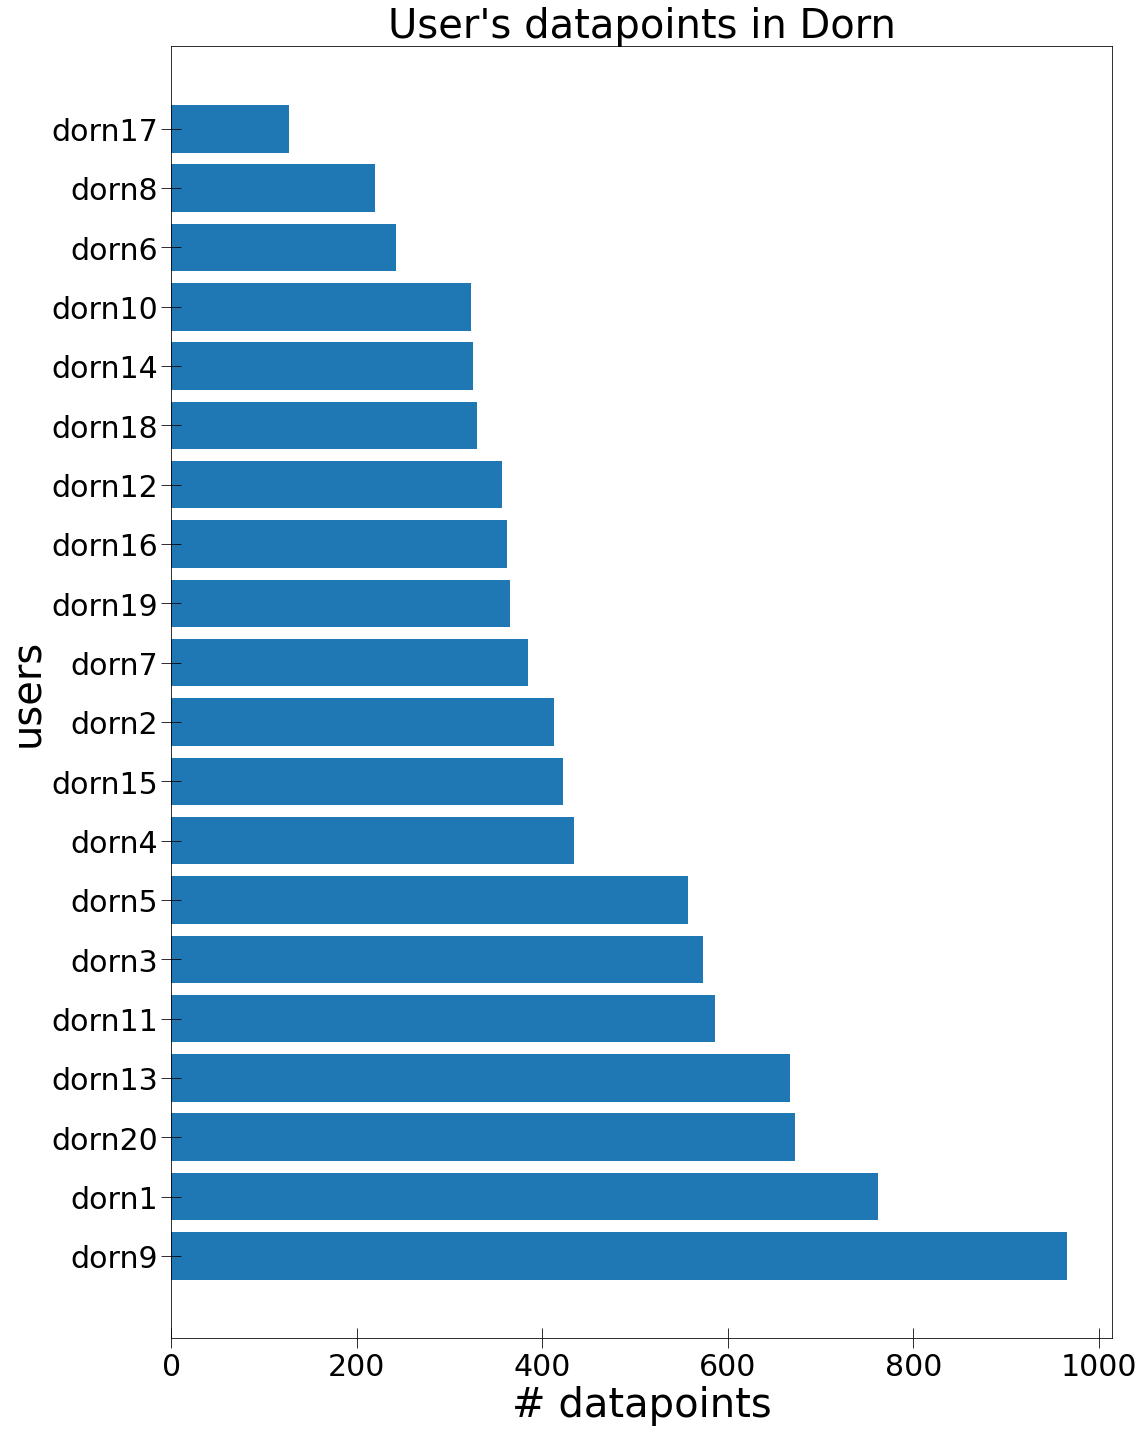

In [5]:
drop_columns = [
    'BMR', # calculated with heigh and weight
    'time',
    # 'air-vel',
    'bodyPresence',
    'change', 
    'comfort',
    'experimentid', 
    'indoorOutdoor', # whether the vote was outside or not
#     'met', # needed for PMV
    'lat',
    'location',
    'restingHR',
    'lon',
    'responseSpeed',
    'voteLog', # sequence of vote
    'unix',
    'CO2',
    'Noise',
    't-skin', # skin temperature ibutton
    't-bag', # ibutton in the backpack
#   't-nb', # near body air temperature ibutton
    't-net', # temperature netatmo
    'rh-net', # humidity netatmo
#   't-ubi', # temperature ubibot
#   'rh-ubi', # humidity ubibot
    'Light',
    't-env', # env features if location is 'other'
    'rh-env', # env features if location is 'other'
    'skin-nb' # extra feature created in previous cell
]
# drop unused features, rename columns, and remap labels
df_dorn_features_filtered = df_dorn_features_indoor.drop(drop_columns, axis=1)
df_dorn_features_filtered = df_dorn_features_filtered.rename(columns={'thermal':'thermal_cozie', 'userid':'user_id'})
df_dorn_features_filtered['thermal_cozie'] = df_dorn_features_filtered['thermal_cozie'].map({'Warmer':9.0,'No Change':10.0, 'Cooler': 11.0})
print(f'Filtered features:\n {df_dorn_features_filtered.columns.values}')

# update `air-vel`
df_dorn_features_filtered['air-vel'] = df_dorn_features_filtered['air-vel'].map({'Yes':1, np.nan:0})

# drop NaN rows regarding physiological and environmental features
print('\nMissing rows:')
print(df_dorn_features_filtered.isna().sum())
print('\nDropping NaNs rows')
non_nans_cols = ['t-nb', 
                 't-ubi',
                 'heartRate',
                 'thermal_cozie']
for col in non_nans_cols:
    df_dorn_features_filtered = df_dorn_features_filtered[df_dorn_features_filtered[col].notna()]
print(df_dorn_features_filtered.isna().sum())

print(f'New dimensions: {df_dorn_features_filtered.shape}')
print(f'New features: {df_dorn_features_filtered.columns.values}')

# remove rows where clothing is 'very light' since it is not an option for commercial buildings
# keep only 'Light' and 'Medium'
df_dorn_features_filtered = df_dorn_features_filtered[
    (df_dorn_features_filtered["clothing"] == "Light") | 
    (df_dorn_features_filtered["clothing"] == "Medium")
]

user_data_dist = df_dorn_features_filtered['user_id'].value_counts()

print(f'Min responses/participant: {min(user_data_dist)}')
print(f'Max responses/participant: {max(user_data_dist)}')

figure, ax = plt.subplots(1, 1, figsize=(16, 20))
ax.barh(user_data_dist.index, user_data_dist, align='center')

ax.tick_params(length=20, direction="inout", labelsize=30)
ax.set_ylabel('users', size=40)
ax.set_xlabel('# datapoints', size=40)
plt.xticks(rotation=0)
ax.set_title('User\'s datapoints in Dorn', size=40)
plt.tight_layout()
plt.show()

figure.savefig(f"img/dorn_datadist_filtered.png")


df_dorn_features_filtered.to_csv('data/dorn/DORN_env.csv', index=False)

# Min responses/participant: 127
# Max responses/participant: 966

## Equal datapoints for all users

In [6]:
# get num_samples of datapoints for users
num_samples = 132
df_dorn_env_same_size = pd.DataFrame()

for user in df_dorn_features_filtered['user_id'].unique():
    df_user = df_dorn_features_filtered[df_dorn_features_filtered['user_id'] == user]
    
    # take the first n samples
    df_user = df_user.iloc[0:num_samples,:]
    df_dorn_env_same_size = df_dorn_env_same_size.append(df_user)
    
df_dorn_env_same_size_pmv = df_dorn_env_same_size.copy()
df_dorn_env_same_size_pmv.to_csv('data/dorn/DORN_env_132_pmv.csv', index=False)
df_dorn_env_same_size = df_dorn_env_same_size.drop("met", axis=1)
df_dorn_env_same_size.to_csv('data/dorn/DORN_env_132.csv', index=False)

print(f'Dimensions with equal size datapoints: {df_dorn_env_same_size.shape}')
print(f'Per user:\n{df_dorn_env_same_size["user_id"].value_counts()}')
print(f'Final features to be use\n: {df_dorn_env_same_size.columns.values}')


Dimensions with equal size datapoints: (2635, 8)
Per user:
dorn1     132
dorn2     132
dorn19    132
dorn18    132
dorn16    132
dorn15    132
dorn14    132
dorn13    132
dorn12    132
dorn11    132
dorn10    132
dorn9     132
dorn8     132
dorn7     132
dorn6     132
dorn5     132
dorn4     132
dorn3     132
dorn20    132
dorn17    127
Name: user_id, dtype: int64
Final features to be use
: ['air-vel' 'clothing' 'heartRate' 'thermal_cozie' 'user_id' 't-nb' 't-ubi'
 'rh-ubi']


In [ ]:
df_dorn = pd.read_csv("data/dorn/DORN_env_132.csv")
vote_by_user(df_dorn, show_percentages=True)


## Preference distribution profiles

/var/folders/1j/2mvzcjvd26795zpd_p3_dhsc0000gn/T/ipykernel_53737/2353262754.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_dist_profile["Thermal Preference"] = df_dist_profile["thermal_cozie"].map(


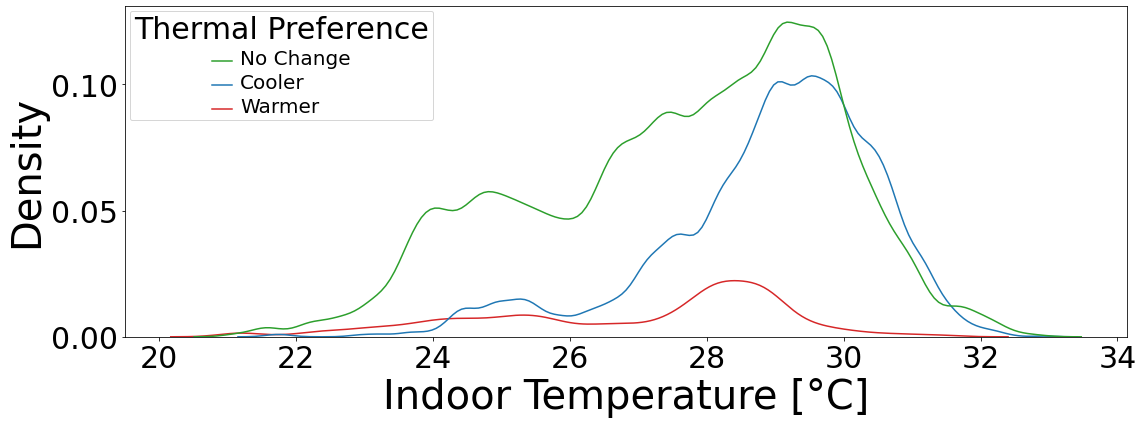

In [7]:
df_dist_profile = df_dorn_features_filtered[['t-ubi','thermal_cozie']]
size = (16,6)
fontsize= 40


df_dist_profile["Thermal Preference"] = df_dist_profile["thermal_cozie"].map(
    {9.0: "Warmer", 10.0: "No Change", 11.0: "Cooler"}
)

fig, ax = plt.subplots(figsize=size)
sns.kdeplot(
    data=df_dist_profile, 
    x="t-ubi", 
    hue="Thermal Preference", 
    bw_adjust=0.5,
    palette=["#2c9f2c", "#1f77b4", "#d62728"], # green, blue, red
    ax=ax
)
plt.xlabel("Indoor Temperature [°C]", size=fontsize)
plt.ylabel("Density", size=fontsize)
plt.tick_params(labelsize=fontsize * 0.75)
plt.savefig(f"img/preferences_dist")
plt.setp(ax.get_legend().get_texts(), fontsize=fontsize*0.5) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=fontsize*0.75) # for legend title
plt.tight_layout()
plt.savefig(f"img/preferences_dist.png")


## Occupant tolerance

In [8]:
df = pd.read_csv('data/dorn/DORN_env_132.csv')
_df = (df.groupby(["user_id", "thermal_cozie"])["thermal_cozie"]
        .count()
        .unstack("thermal_cozie")
)
_df.reset_index(inplace=True)

df_total = _df.sum(axis=1)
df_rel = _df[_df.columns[1:]].div(df_total, 0) * 100
df_rel["user_id"] = _df["user_id"]

df_tolerance = pd.DataFrame()
df_tolerance["user_id"] = df_rel["user_id"]
df_tolerance["tolerance"] = df_rel.iloc[:,1]
df_tolerance.to_csv("data/dorn/DORN_tol_132.csv")
print(df_tolerance)

df = pd.read_csv('data/dorn/DORN_env.csv')
_df = (df.groupby(["user_id", "thermal_cozie"])["thermal_cozie"]
        .count()
        .unstack("thermal_cozie")
)
_df.reset_index(inplace=True)

df_total = _df.sum(axis=1)
df_rel = _df[_df.columns[1:]].div(df_total, 0) * 100
df_rel["user_id"] = _df["user_id"]

df_tolerance = pd.DataFrame()
df_tolerance["user_id"] = df_rel["user_id"]
df_tolerance["tolerance"] = df_rel.iloc[:,1]
df_tolerance.to_csv("data/dorn/DORN_tol.csv")
print(df_tolerance)


   user_id  tolerance
0    dorn1  92.424242
1   dorn10   4.545455
2   dorn11  81.060606
3   dorn12  50.000000
4   dorn13  61.363636
5   dorn14  96.212121
6   dorn15  65.151515
7   dorn16   6.060606
8   dorn17  72.440945
9   dorn18  63.636364
10  dorn19  47.727273
11   dorn2  84.090909
12  dorn20  79.545455
13   dorn3  65.151515
14   dorn4  78.030303
15   dorn5  69.696970
16   dorn6  31.818182
17   dorn7  31.060606
18   dorn8  54.545455
19   dorn9  12.121212
   user_id  tolerance
0    dorn1  97.506562
1   dorn10   1.857585
2   dorn11  86.348123
3   dorn12  67.415730
4   dorn13  77.811094
5   dorn14  98.153846
6   dorn15  54.028436
7   dorn16  11.602210
8   dorn17  72.440945
9   dorn18  70.909091
10  dorn19  56.712329
11   dorn2  81.355932
12  dorn20  88.392857
13   dorn3  65.270506
14   dorn4  24.654378
15   dorn5  84.201077
16   dorn6  40.909091
17   dorn7  27.604167
18   dorn8  61.818182
19   dorn9   3.933747


/var/folders/1j/2mvzcjvd26795zpd_p3_dhsc0000gn/T/ipykernel_53737/1412315547.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_total = _df.sum(axis=1)
/var/folders/1j/2mvzcjvd26795zpd_p3_dhsc0000gn/T/ipykernel_53737/1412315547.py:25: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df_total = _df.sum(axis=1)


## Preference distribution

In [3]:
 # TODO: move this to a function in utils
df_tol = pd.read_csv("data/dorn/DORN_tol.csv")
df = pd.read_csv('data/dorn/DORN_env.csv')
tol = 0.6

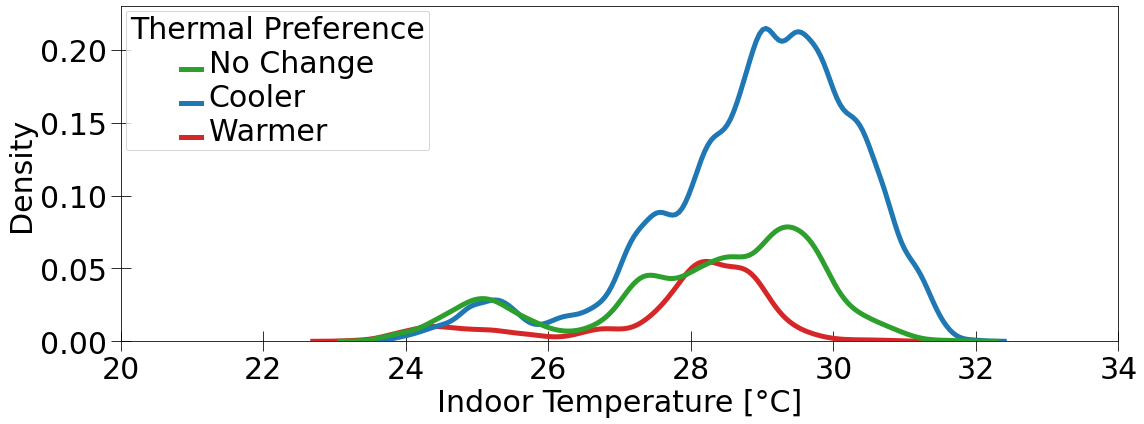

In [4]:
filtered_occ = list(df_tol[df_tol["tolerance"] <= tol*100]["user_id"])
df_filtered = df[df["user_id"].isin(filtered_occ)]

df_dist_profile = df_filtered[['t-ubi','thermal_cozie']]
size = (16,6)
fontsize= 40

df_dist_profile_plot = df_dist_profile.copy()

df_dist_profile_plot["Thermal Preference"] = df_dist_profile["thermal_cozie"].map(
    {9.0: "Warmer", 10.0: "No Change", 11.0: "Cooler"}
)

if tol == 0.1:
    palette=["#1f77b4", "#2c9f2c", "#d62728"] # blue, green, red
else:
    palette=["#2c9f2c", "#1f77b4", "#d62728"] # green, blue, red
    
fig, ax = plt.subplots(figsize=size)
kde = sns.kdeplot(
    data=df_dist_profile_plot, 
    x="t-ubi", 
    hue="Thermal Preference", 
    bw_adjust=0.5,
    palette=palette,
    linewidth=5,
    ax=ax
)

plt.xlabel("Indoor Temperature [°C]", size=fontsize*0.75)
plt.ylabel("Density", size=fontsize*0.75)
plt.ylim([0.0, 0.23])
plt.xlim([20, 34])
plt.tick_params(labelsize=fontsize * 0.75)
ax.tick_params(length=20, direction="inout", labelsize=fontsize*0.75)
plt.setp(ax.get_legend().get_texts(), fontsize=fontsize*0.75) # for legend text
plt.setp(ax.get_legend().get_title(), fontsize=fontsize*0.75) # for legend title

# plt.xlabel("", size=fontsize)
# plt.ylabel("", size=fontsize)
# ax.get_legend().remove()
# ax.set_xticklabels([])
# ax.set_yticklabels([])

plt.tight_layout()
plt.savefig(f"img/preferences_dist_tol{tol}.png")
